## Electrodermal activity (EDA/GSR)

Materials are based on [Jupyter Notebooks](https://biosignalsplux.com/learn/notebooks.html) by biosignalsplux (see the [LICENSE](https://github.com/biosignalsplux/biosignalsnotebooks/blob/master/LICENSE)).

### Required packages

We will use special package created by biosignalsplux - as it is non-standard, we need to install it now:

In [ ]:
# install necessary packages
!pip install biosignalsnotebooks

# install also system libraries necessary for libmagic
!apt-get install libmagic-dev

# install biosppy and neurokit2 (will be used at the end of the notebook)
!pip install biosppy neurokit2

In [ ]:
# necessary imports
import numpy as np
import pandas as pd
import biosignalsnotebooks as bsnb
import bokeh
bokeh.io.output_notebook()
from scipy import signal

# some packages for EDA
import pywt
import copy
import sklearn.mixture
import scipy.stats

### Let's load some EDA data!

The notebook uses the sample EDA signals provided by biosignalsplux. But it may be more interesting to load your own signal recorded during the class!

In [ ]:
# Download the sample dataset (to Virtual Machine local filesystem)
# note the leading !. This is a signal to execute the line as a shell command
!wget https://krzysztof.kutt.pl/didactics/psaw/EDA_sample.txt

In [ ]:
# to load your own data, change the filename accordingly
data, header = bsnb.load("EDA_sample.txt", get_header=True)

In [ ]:
# print the data
print(f"Header:\n{str(header)}\nData:\n{str(data)}")

There is only one channel (`'CH3'`) and it contains EDA data (`'sensor': ['EDABITREV']`).

Now, it's time to plot the data to see how it looks like.  
As with the other signals, there is a need to generate time vector (using `header['sampling rate']`).

In [ ]:
raw_eda = data["CH3"]
sr = header["sampling rate"]
eda_len = raw_eda.shape[0]
time = np.linspace(start=0, stop=eda_len/sr, num=eda_len)

**Task 1**: plot the signal in time. Do not forget to label the axes!  
Use `matplotlib` or `bokeh`, whichever you like more.

In [ ]:
bf = bokeh.plotting.figure(
    x_axis_label='Time',
    y_axis_label='EDA',
    plot_width=800,
    plot_height=400)
bf.line(time, raw_eda)
bokeh.plotting.show(bf)

Before the analysis, we need to **convert the units** (as during the ECG lab).

**Side task:** If you are analysing your own data collected in the lab, read the documentation (see [EDA_Datasheet.pdf](https://krzysztof.kutt.pl/didactics/psaw/EDA_Datasheet.pdf)), and adjust the `convert_to_eda(raw_signal)` function accordingly.

In [ ]:
# The function is pre-prepared to sample data (as it was gathered with previous sensor version)
def convert_to_eda(raw_signal):
  n = header["resolution"][-1]
  vcc = 3.3
  g_eda = 0.132

  return ((raw_signal / 2**n) * vcc) / g_eda

In [ ]:
# apply the function
converted_eda = convert_to_eda(raw_eda)

# and plot the result
bf = bokeh.plotting.figure(x_axis_label='Time (s)', y_axis_label='EDA (μS)', plot_width=800, plot_height=250)
bf.line(time, converted_eda)
bokeh.plotting.show(bf)

### EDA signal

The EDA signal can be split into two components (see the image below):
* *Skin Conductance Level (SCL)* -- a slow signal that fluctuates as temperature or general nervousness changes, among other things. It is not particularly useful in HCI, but we need to identify it to determine the other, more important, SCR component.
* *Skin Conductance Response (SCR)* -- a rapid change in the signal, resulting in a peak. It can be further divided into two groups:
  * *Event-Related SCR (ER-SCR)* -- the peak occurs in response to a stimulus (e.g., a sound in an experiment, or the appearance of a particular scene in a movie),
  * *Non-Specific SCR (NS-SCR)* -- the peak is not related to any stimulus.  

*It can be seen as a more advanced baseline correction task*

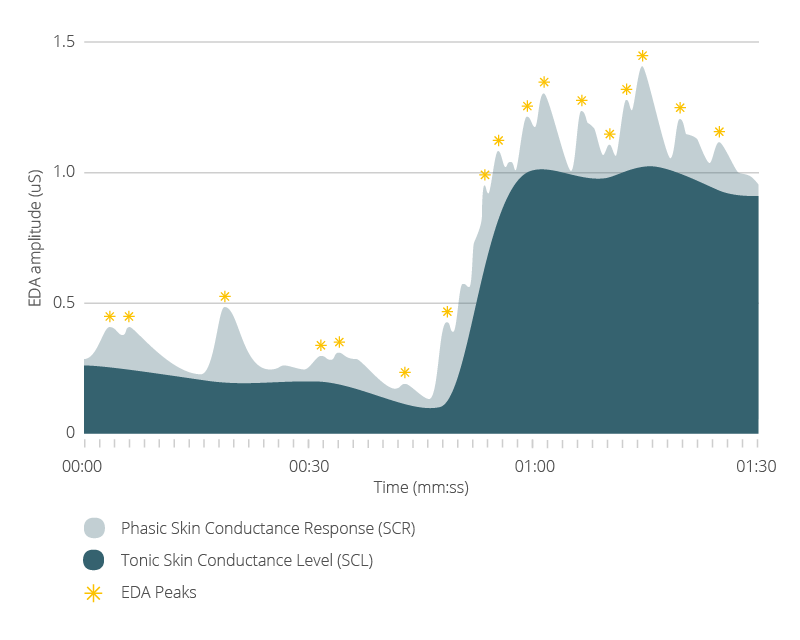

Typical EDA characteristics used in HCI studies ([source](https://doi.org/10.1017/CBO9780511546396)):
* SCL
* Change in SCL - Gradual changes in SCL measured at two or more points in time
* Frequency of NS-SCRs
* SCR amplitude
* SCR latency - temporal interval between stimulus onset and SCR initiation
* SCR rise time - temporal interval between SCR initiation and SCR peak
* SCR half recovery time - temporal interval between SCR peak and point of 50% recovery of SCR amplitude
* SCR habitation (trials to habituation) - number of stimulus presentations before two or three trials with noresponse
* SCR habituation (slope) - Rate of change of ER-SCR amplitude

They are summarized on the figure below ([source](https://doi.org/10.1017/CBO9780511546396)).

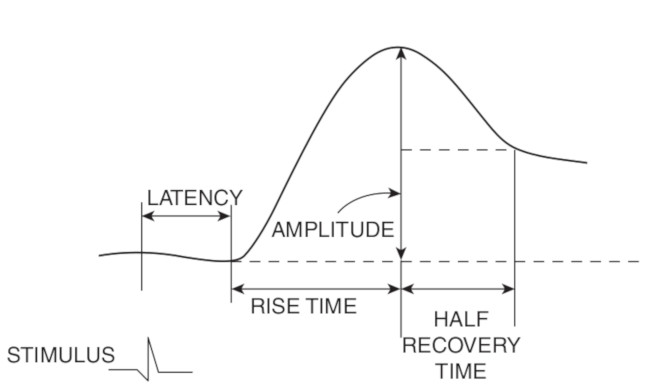

### Filtering

In research literature it is considered that the typical informational band of EDA signal is in the range:
* [0; 3] Hz ([source](https://biosignalsplux.com/index.php/eda-electrodermal-activity))
* [0; 10] Hz ([source](https://arxiv.org/pdf/1608.06986.pdf))
* [0.016; 5] Hz ([source](https://books.google.pt/books?id=6N6rnOEZEEoC&pg=PA511&lpg=PA511&dq=electrodermal+signal+bandpass.&source=bl&ots=B2nCotFOLy&sig=ACfU3U1ywe-PWzZrUSN75RljGSGxwWkgVQ&hl=pt-PT&sa=X&ved=2ahUKEwiy35LRorTkAhUcAGMBHcOeCosQ6AEwGnoECAkQAQ#v=onepage&q=electrodermal%20signal%20bandpass.&f=false))
* [0.0167; 0.25] Hz ([source](https://www.sciencedirect.com/science/article/abs/pii/S1746809418300090))
* [0.045; 0.25] Hz ([source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5983430/))
* [0.05; 35] Hz ([source](https://www.birmingham.ac.uk/Documents/college-les/psych/saal/guide-electrodermal-activity.pdf))

**Task 2**: As you can see, the range is very wide - so let's start by comparing the narrowest range and the widest range. To do this:
1. Prepare two filters:
  * wide range: lowpass (35 Hz)
  * narrow range: select one of the ranges from the list above and prepare the appropriate bandpass filter
2. Plot three lines (`converted_eda`, `wide_filtered_eda`, `narrow_filtered_eda`) on one plot. As narrow filters can result in a signal of smaller amplitude, it is useful to move the data when plotting, i.e., plot `narrow_filtered_eda + (converted_eda[0]-narrow_filtered_eda[0])` instead of `narrow_filtered_eda`.
3. Describe your own thoughts - which of them is better and why? (or when?)

Note: we will use [Butterworth filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html) instead of the FIR and apply the filter using [filtfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html) - you can compare results of this and previous approach if you are interested in details :)

In [ ]:
# apply wide range filter

cutoff = 30
filt_order = 2  # you can experiment with this value!
b, a = signal.butter(filt_order, cutoff, fs=sr, btype='lowpass')
wide_filtered_eda = signal.filtfilt(b, a, converted_eda)

In [ ]:
# apply selected narrow range filter

cutoff = (0.016, 5)
filt_order = 1  # you can experiment with this value!
b, a = signal.butter(filt_order, cutoff, fs=sr, btype='bandpass')
narrow_filtered_eda = signal.filtfilt(b, a, converted_eda)

In [ ]:
# prepare the plot
narrow_filtered_eda = narrow_filtered_eda + (converted_eda[0]-narrow_filtered_eda[0])
bf2 = bokeh.plotting.figure(
    x_axis_label='Time (s)',
    y_axis_label='EDA (μS)',
    plot_width=900,
    plot_height=250)
bf2.line(time, converted_eda,
         legend_label='Original', color='blue')
bf2.line(time, wide_filtered_eda,
         legend_label='Wide_filtered', color='red')
bf2.line(time, narrow_filtered_eda,
         legend_label='Narrow_filtered', color='green')
bokeh.plotting.show(bf2)

**Response (for Task 2, point 3):** 
Oba filtry dają podobny wynik, ale lepszym wyborem może być 'lowpass'.

### Artifacts removal

As you can see, a low-pass filter (35 Hz) is best, as it does not remove the SCR component from the signal. Unfortunately, there remains a lot of artifacts that has to be removed.

It will be filtered using wavelet transform. Wavelet transforms are useful in signal filtering, as there are more signal-friendly than classical filters (many new articles deal with methods for filtering various signals in this way). For a short introduction, see, e.g., [https://www.centerspace.net/wavelet-transforms](https://www.centerspace.net/wavelet-transforms).

Here, we will follow the algorithm described in [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5413204/).


*There are no tasks in this section. Simply run the code and see what happens.*

In [ ]:
# SWT 8th level Decomposition using "Haar" mother wavelet (taking into consideration its ability to detect "edges" in the signal)
# We calculate it using only first 32768 to be able to perform level 8
swt_orig_coeffs = pywt.swt(wide_filtered_eda[:32768], "haar", level=8)

# Restriction of filtering algorithm to the coefficients of the last decomposition level.
detail_coeffs = swt_orig_coeffs[0][1]
scaling_coeffs = swt_orig_coeffs[0][0]

"One Gaussian component describes coefficients centered around zero, and the other describes those spread out at larger values... The Gaussian with smaller variance corresponds to the wavelet coefficients of <strong>Skin Conductance Level (SCL)</strong>, while the Gaussian with larger variance corresponds to the wavelet coefficients of <strong>Skin Conductance Responses (SCRs)</strong>"

In [ ]:
# Generation of a Gaussian Mixture model
gaussian_mixt = sklearn.mixture.GaussianMixture(n_components=2, covariance_type="spherical")

# Reshape data to a column vector format.
detail_coeffs_col = np.reshape(detail_coeffs, (len(detail_coeffs), 1))

# Fit data to our model object.
gaussian_mixt.fit(detail_coeffs_col)

Determination of the Cumulative Density Function ($\Phi_{mixt}$) of the previously defined Gaussian Mixture.

\begin{equation}
\Phi_{mixt} = weight_1 \times \Phi_1 + weight_2 \times \Phi_2
\end{equation}

being $weight_1$ and $weight_2$ the relative contribution of each mixture component ($weight_1 + weight_2 = 1$) and $\Phi_1$ and $\Phi_2$ the normal cumulative distribution functions from the original component normal distributions $N(0, \sigma_1^2)$ and $N(0, \sigma_2^2)$. 

In [ ]:
# Normal distribution function objects.
norm_1 = scipy.stats.norm(loc=gaussian_mixt.means_[0][0], scale=np.sqrt(gaussian_mixt.covariances_[0])) 
norm_2 = scipy.stats.norm(loc=gaussian_mixt.means_[1][0], scale=np.sqrt(gaussian_mixt.covariances_[1])) 

# Component weights.
weight_1 = gaussian_mixt.weights_[0]
weight_2 = gaussian_mixt.weights_[1]

# CDF values for the coefficients under analysis.
sort_detail_coeffs = np.sort(detail_coeffs)
norm_1_cdf = norm_1.cdf(sort_detail_coeffs)
norm_2_cdf = norm_2.cdf(sort_detail_coeffs)

# CDF of the Gaussian mixture.
cdf_mixt = weight_1 * norm_1_cdf + weight_2 * norm_2_cdf

In [ ]:
 bsnb.plot([sort_detail_coeffs], [cdf_mixt], y_axis_label="Cumulative Distribution Probability", x_axis_label ="Wavelet Coefficient Values", legend_label=["CDF Function"])

Definition of motion artifact removal thresholds using the Cumulative Distribution Function (CDF) of the previously defined Gaussian Mixture model, considering an artifact proportion value $\delta$ equal to 0.01

In [ ]:
art_prop = 0.01 # Artifact proportion value.
low_thr = None 
high_thr = None

# Check when the CDF mixture function reaches values art_prop / 2 and 1 - art_prop / 2.
for i in range(0, len(norm_1_cdf)):
    # Low threshold clause
    if cdf_mixt[i] - cdf_mixt[0] >= art_prop and low_thr == None:
        low_thr = sort_detail_coeffs[i]
        
    # High threshold clause
    if cdf_mixt[-1] - cdf_mixt[i] <= art_prop and high_thr == None:
        high_thr = sort_detail_coeffs[i]

Removal of wavelet coefficients related with motion artifacts
\begin{equation}
d_{2^j}^{2^jk + p} = \begin{cases} d_{2^j}^{2^jk + p}, & \mbox{if } T_{low} < d_{2^j}^{2^jk + p} < T_{high}\\ 0, & otherwise \end{cases}
\end{equation}

being $d_{2^j}^{2^jk + p}$ the detail coefficient for the $j$ wavelet scale, translation $k$ and shift $p$. $T_{low}$ and $T_{High}$ define the determined lower and higher artifact removal thresholds stored in <strong>low_thr</strong> and <strong>high_thr</strong> variables.

In [ ]:
filt_detail_coeffs = copy.deepcopy(detail_coeffs)
count_1 = 0
count_2 = 0
for j in range(0, len(filt_detail_coeffs)):
    if detail_coeffs[j] <= low_thr or detail_coeffs[j] >= high_thr:
        filt_detail_coeffs[j] = 0
    else:
        continue
        
# Update of the SWT decomposition tuple
swt_coeffs = [(np.array(scaling_coeffs), np.array(filt_detail_coeffs))]

Signal reconstruction through an inverse SWT

In [ ]:
reconstructed_eda = pywt.iswt(swt_coeffs, "haar")

In [ ]:
# Plot the results (we plot the normalized data, as the reconstructed signal has lower amplitude)

colors = bokeh.palettes.brewer['Paired'][3]
bf = bokeh.plotting.figure(x_axis_label='Time (s)', y_axis_label='Normalized EDA', plot_width=800, plot_height=250)
bf.line(time[:32768], wide_filtered_eda[:32768]/np.max(wide_filtered_eda[:32768]), alpha=0.8, line_width=2, color=colors[0], legend_label="Lowpass (35 Hz)")
bf.line(time[:32768], reconstructed_eda/np.max(reconstructed_eda), alpha=0.8, line_width=2, color=colors[1], legend_label="Reconstructed EDA")
bf.legend.click_policy="hide"
bokeh.plotting.show(bf)

### Smoothing

**Task 3**: Finaly, we want to perform some signal smoothing via a moving average window.

In [ ]:
# To perform this step you can simply convolve envelope with proper rectangle window:
# np.ones(window_size)/window_size
# -- remember to divide by window_size as this is required for averaging all values!
# The window size can be chosen experimentally. You can start with 0.3 * sampling_rate

window_size = int(0.3 * sr)
window_filter = np.ones(window_size) / window_size
smoothed_eda = np.convolve(reconstructed_eda, window_filter, mode='same')



In [ ]:
# As signal has very low amplitude, we will rescale it to the original one
smoothed_eda = smoothed_eda * (np.max(wide_filtered_eda) / np.max(smoothed_eda))

In [ ]:
# Plot the smoothing result

colors = bokeh.palettes.brewer['Paired'][4]
bf = bokeh.plotting.figure(x_axis_label='Time (s)', y_axis_label='Normalized EDA', plot_width=800, plot_height=250)
bf.line(time[:32768], wide_filtered_eda[:32768]/np.max(wide_filtered_eda[:32768]), alpha=0.8, line_width=2, color=colors[0], legend_label="Lowpass (35 Hz)")
bf.line(time[:32768], reconstructed_eda/np.max(reconstructed_eda), alpha=0.8, line_width=2, color=colors[1], legend_label="Reconstructed EDA")
bf.line(time[:32768], smoothed_eda/np.max(smoothed_eda), alpha=0.8, line_width=2, color=colors[2], legend_label="Smoothed EDA")
bf.legend.click_policy="hide"
bokeh.plotting.show(bf)

### Features extraction

On the figure above (if you use the EDA\_sample) you have **exactly one** EDA peak. As we finally filtered it, we can extract some features!

**Task 4**: Calculate:
* SCR amplitude - difference between baseline and the peak
* SCR latency - temporal interval between stimulus onset and SCR initiation
* SCR rise time - temporal interval between SCR initiation and SCR peak
* SCR half recovery time - temporal interval between SCR peak and point of 50% recovery of SCR amplitude

You can calculate them by hand or use a dedicated library.

In [ ]:
scr_amplitude = 1 - 0.712
scr_latency = 7 - 0
scr_rise_time = 10.9 - 7
scr_half_recovery_time = 27 - 10.9

print(f'Amplitude: {scr_amplitude}\n' +
      f'Latency: {scr_latency}\n' +
      f'Rise time: {scr_rise_time}\n' +
      f'Recovery: {scr_half_recovery_time}\n')

### BioSPPy and Neurokit2

As you may remember from ECG lab, there is also the BioSPPy tools. Now, we will see, how it works for EDA signal.

The **Neurokit2** may also be useful. If you want to know more, the short tutorial for EDA signals is provided [here](https://neurokit2.readthedocs.io/en/latest/examples/eda.html).

In [ ]:
# import the library
import biosppy

**Task 5**: The major method for EDA signal in BioSPPy is [`biosppy.signals.eda.eda()`](https://biosppy.readthedocs.io/en/stable/biosppy.signals.html#biosppy.signals.eda.eda). Your task is to use this method to our sample signal and check how well BioSPPy performs its tasks!

* Try various signals as `signal` parameter (`raw_eda`, `converted_eda`, `wide_filtered_eda`, `smoothed_eda`). What are the differences in performance?
* Manipulate the `min_amplitude` to adjust the results.
* Remember to set the `sampling_rate` to proper value (and `show=True` to see the plots).
* This method not only displays graphs, but also returns some results - review these values and compare with your own calculated in Task 4!

As a response, note your observations below.

In [ ]:
biosppy.signals.eda.eda(signal=raw_eda, sampling_rate=1000.0, show=True, min_amplitude=0.1)
biosppy.signals.eda.eda(signal=converted_eda, sampling_rate=1000.0, show=True, min_amplitude=0.1)
biosppy.signals.eda.eda(signal=wide_filtered_eda, sampling_rate=1000.0, show=True, min_amplitude=0.1)
biosppy.signals.eda.eda(signal=smoothed_eda, sampling_rate=1000.0, show=True, min_amplitude=0.1)

**Response (for Task 5):** Otrzymane wyniki przy użyciu biblioteki lekko różnią się od oczekiwanych gdyż następuje przesunięcie. 